<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Сводная-таблица" data-toc-modified-id="Сводная-таблица-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Сводная таблица</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Цели и задачи

Компания Такси собрала исторические данные о заказах такси в аэропортах. 
**Цель:**
 - Спрогнозировать количество заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки. Построить модель для такого прогнозирования.


**Задачи:**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.



## Подготовка данных

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None 
import warnings
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Проверка индексов на монотонность:

In [3]:
df.index.is_monotonic

True

Text(0.5, 1.0, 'Orders made (every ten minutes data)')

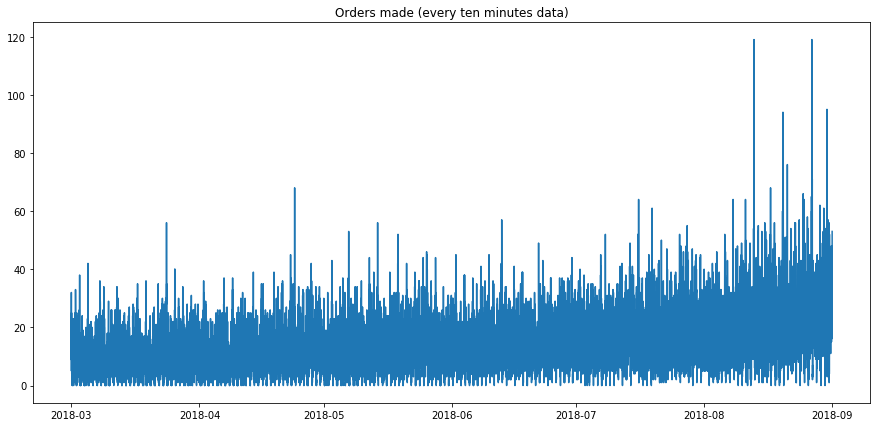

In [4]:
plt.figure(figsize=(15, 7))
plt.plot(df)
plt.title('Orders made (every ten minutes data)')

Данные предоставлены за период с 1 марта по 31 августа с шагом 10 минут. Сортировка выполнена успешно. 

Выполнили ресемплирование данных по одному часу:

In [5]:
df= df.resample('1H').sum()

Проверка ресемплирования:

In [6]:
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Анализ данных

Возьмем выборочно несколько дат и построим графики для понимания зависимости параметра от времени.

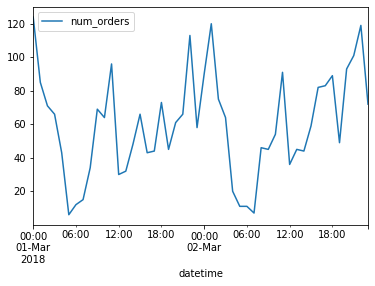

In [7]:
df['2018-03-01':'2018-03-02'].plot()

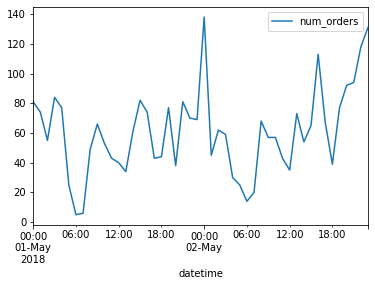

In [8]:
df['2018-05-01':'2018-05-02'].plot()

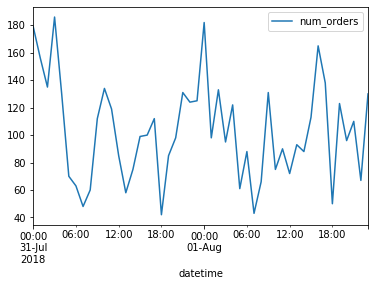

In [9]:
df['2018-07-31':'2018-08-01'].plot()

Выполнили декомпозицию данных (trend, seasonality, residuals) и вывели их графики. 

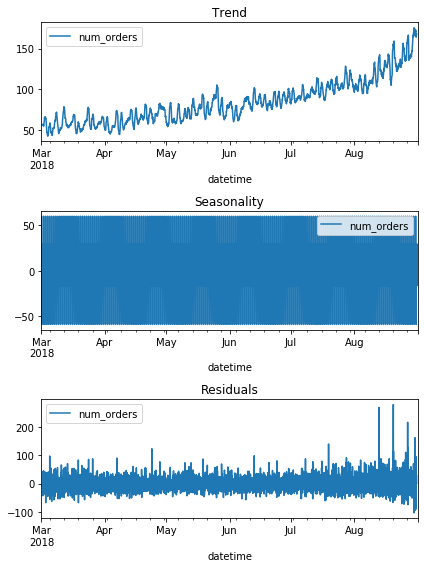

In [10]:
decomposed = seasonal_decompose(df)
plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()


За такой большой период невозможно увидеть сезонность, поэтому возьмем первые 15 дней марта 2018 года. 

Text(0.5, 1.0, 'Seasonality for the first fiften days of March')

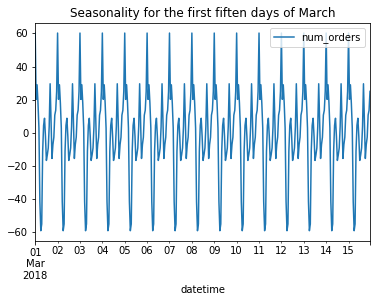

In [11]:
decomposed.seasonal['2018-03-01':'2018-03-15'].plot(ax=plt.gca())
plt.title('Seasonality for the first fiften days of March')

**Сезонность** - большая часть заказов совершается в ночное время (около 12.00). Затем заказы постепенно снижаются и в 6.00 достигают минимальной точки. Это может быть связано с тем, что днем пока ходит общественный транспорт, часть пассажиров выбирает именно его, а ночью едут на такси. Заметно, что в рабочее время поступает меньше заказов. 

В выборке прослеживается заметный **тренд** в том, что наблюдается постоянное увеличение заказов. 

Вывели график целового признака и скольжений средних и отклонений с окном равным 24. 

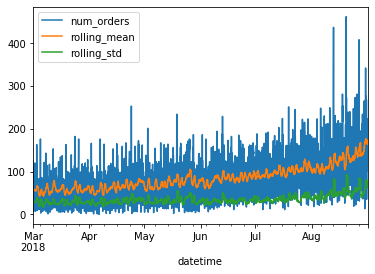

In [12]:
df['rolling_mean'] = df['num_orders'].rolling(24).mean()
df['rolling_std'] = df['num_orders'].rolling(24).std()
df.plot()

Можем видеть, что хоть и происходит увеличение заказов, но ряд не сильно изменяется во времени, поэтому можно работать с ним как со стационарным. Поэтому не будем применять разности временного ряда. Примем, что его распределение не зависит от времени. Так как ряд стационарный, данные можно прогнозировать

## Обучение

Перед обучением проверим корректность разделения данных на выборки.

Необходимо создать признаки. Напишем функцию которая создаст следующие типы признаков:
 - календарные признаки (добавим месяц, день недели и часы);
 - отстающее значение (получим отстающие значения функцией shift(), чтобы посмотреть будет ли функция x(t) расти или уменьшаться);
 - скользящее среднее (скользящее среднее как признак задаёт общий тренд временного ряда, вычисление скользящего среднего не должно включать в себя текущее значение ряда).
    

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    
    #data['month'] = data.index.month
    data['dayofweek'] = data.index.dayofweek
    data['hour']=data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Создадим тестовую выборку размером 10% от исходных данных:

In [14]:
make_features(df, 1, 1) #Берем любые значения для max_lag и rolling_mean_size

train, test = train_test_split(df, shuffle=False, test_size=0.1)

train = train.dropna() #Удалим пропуски

#Распределим целовой признак
features_train = train.drop('num_orders', axis=1)
features_test = test.drop('num_orders', axis=1)
target_train = train['num_orders']
target_test = test['num_orders']

Проверим правильность разделения данных на две выборки.

In [15]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 23:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Данные разбились корректно: обучающая выборка заканчивается 13 августа в 13.00, а тестовая выборка начинается 13 августа в 14.00.

Подберем лучшие параметры для функции "make_features" и проверим данные на разных моделях с подбором необходимых гиперпараметров! 

Модель **"Линейная регрессия"**:

In [16]:
best_size_lr = 0
best_lag_lr = 0
best_result_lr=1000

for lag_lr in range(1, 10, 1):
    for rolling_size_lr in range(12, 2000, 12):
        
        make_features(df, lag_lr, rolling_size_lr)

        train, test = train_test_split(df, shuffle=False, test_size=0.1)
        train = train.dropna()
        features_train = train.drop('num_orders', axis=1)
        features_test = test.drop('num_orders', axis=1)
        target_train = train['num_orders']
        target_test = test['num_orders']

        model_lr = LinearRegression()
        model_lr.fit(features_train, target_train) 
        pred_test = model_lr.predict(features_test) 
        result_lr = mean_squared_error(target_test, pred_test)**0.5
        
        if result_lr < best_result_lr:
            best_result_lr = result_lr
            best_lag_lr = lag_lr
            best_size_lr = rolling_size_lr

print('Показатель RMSE: {:.2f}'.format(best_result_lr))
print('Показатель lag:', best_lag_lr)
print('Показатель rolling_size:', best_size_lr)

Показатель RMSE: 49.21
Показатель lag: 5
Показатель rolling_size: 408


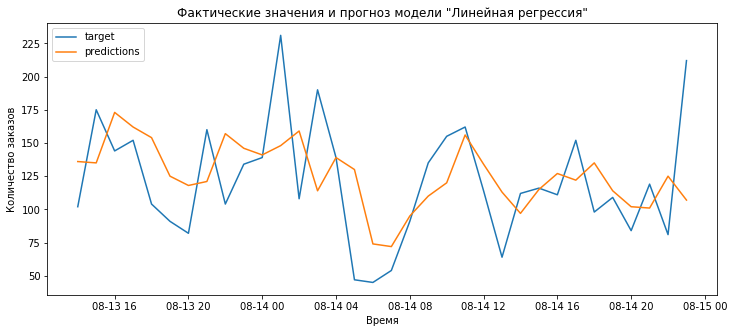

In [17]:
make_features(df, best_lag_lr, best_size_lr)

train_1, test_1 = train_test_split(df, shuffle=False, test_size=0.1)
train_1 = train_1.dropna()
features_train_1 = train_1.drop('num_orders', axis=1)
features_test_1 = test_1.drop('num_orders', axis=1)
target_train_1 = train_1['num_orders']
target_test_1 = test_1['num_orders'].reset_index()

model_lr = LinearRegression()
model_lr.fit(features_train_1, target_train_1)
pred_test_1 = model_lr.predict(features_test_1)

pred_test_lr = pd.Series(pred_test_1)
target_test_lr = pd.concat([target_test_1, pred_test_lr], axis=1)
target_test_lr = target_test_lr.set_index('datetime')
target_test_lr.columns = ['target_test', 'pred_test']
target_test_lr['pred_test'] = target_test_lr['pred_test'].round()
target_test_lr.pred_test = target_test_lr.pred_test.astype(int)
df_for_plot = target_test_lr['2018-08-13':'2018-08-14']
plt.figure(figsize=(12,5))
plt.plot(df_for_plot['target_test'], label='target')
plt.plot(df_for_plot['pred_test'], label='predictions')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.title('Фактические значения и прогноз модели "Линейная регрессия"')

plt.legend()
plt.show()


Модель **"Дерево решений"**:

In [18]:
best_size_dt = 0
best_lag_dt = 0
best_model_dt = None
best_result_dt = 1000
for lag_dt in range(1, 10, 1):
    for rolling_size_dt in range(12, 2000, 12):
        
        make_features(df, lag_dt, rolling_size_dt)

        train, test = train_test_split(df, shuffle=False, test_size=0.1)
        train = train.dropna()
        features_train = train.drop('num_orders', axis=1)
        features_test = test.drop('num_orders', axis=1)
        target_train = train['num_orders']
        target_test = test['num_orders']
       
        for depth in range(1, 20, 1):
            model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
            model.fit(features_train, target_train) # Обучили модель на тренировочной выборке
            pred_test = model.predict(features_test) # Вычислили качество модели на тестовой выборке
            result = mean_squared_error(target_test, pred_test)**0.5
            if result < best_result_dt:
                best_model_dt = model
                best_result_dt = result
                best_lag_dt = lag_dt
                best_size_dt = rolling_size_dt

print('Лучшая модель со след. параметрами:', '\n', best_model_dt)
print('Показатель RMSE: {:.2f}'.format(best_result_dt))
print('Показатель lag:', best_lag_dt)
print('Показатель rolling_size:', best_size_dt)

Лучшая модель со след. параметрами: 
 DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=12345, splitter='best')
Показатель RMSE: 44.51
Показатель lag: 1
Показатель rolling_size: 816


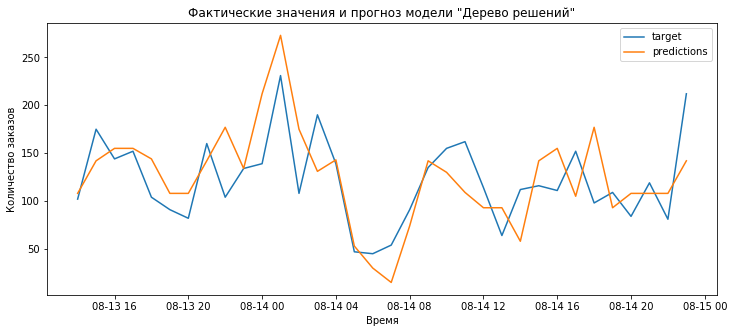

In [19]:
make_features(df, best_lag_dt, best_size_dt)

train_2, test_2 = train_test_split(df, shuffle=False, test_size=0.1)
train_2 = train_2.dropna()
features_train_2 = train_2.drop('num_orders', axis=1)
features_test_2 = test_2.drop('num_orders', axis=1)
target_train_2 = train_2['num_orders']
target_test_2 = test_2['num_orders'].reset_index()

model_dt = DecisionTreeRegressor(random_state=12345, max_depth=10)
model_dt.fit(features_train_2, target_train_2)
pred_test_2 = model_dt.predict(features_test_2)

pred_test_dt = pd.Series(pred_test_2)
target_test_dt = pd.concat([target_test_2, pred_test_dt], axis=1)
target_test_dt = target_test_dt.set_index('datetime')
target_test_dt.columns = ['target_test', 'pred_test']
target_test_dt['pred_test'] = target_test_dt['pred_test'].round()
target_test_dt.pred_test = target_test_dt.pred_test.astype(int)
df_for_plot_dt = target_test_dt['2018-08-13':'2018-08-14']
plt.figure(figsize=(12,5))
plt.plot(df_for_plot_dt['target_test'], label='target')
plt.plot(df_for_plot_dt['pred_test'], label='predictions')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.title('Фактические значения и прогноз модели "Дерево решений"')

plt.legend()
plt.show()

Модель **"Случайный лес"**
Параметры для функции "make_features" приняты, как у модели "Дерево решений", так как практически проверено, что эти параметры дают лучший результат для модели. 

In [20]:
best_model_rf = None
best_result_rf = 1000

make_features(df, best_lag_dt, best_size_dt)

train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
features_train = train.drop('num_orders', axis=1)
features_test = test.drop('num_orders', axis=1)
target_train = train['num_orders']
target_test = test['num_orders']
       
for est in range(5,21, 5):
    for depth in range(1, 15, 1):
        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train) 
        pred_test = model.predict(features_test) 
        result = mean_squared_error(target_test, pred_test)**0.5
        if result < best_result_rf:
            best_result_rf = result
            best_model_rf = model
            best_lag_rf = best_lag_dt
            best_size_rf = best_size_dt

print('Лучшая модель со след. параметрами:', '\n', best_model_rf)
print('Показатель RMSE: {:.2f}'.format(best_result_rf))
print('Показатель lag:', best_lag_rf)
print('Показатель rolling_size:', best_size_rf)

Лучшая модель со след. параметрами: 
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=13,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=20,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)
Показатель RMSE: 41.40
Показатель lag: 1
Показатель rolling_size: 816


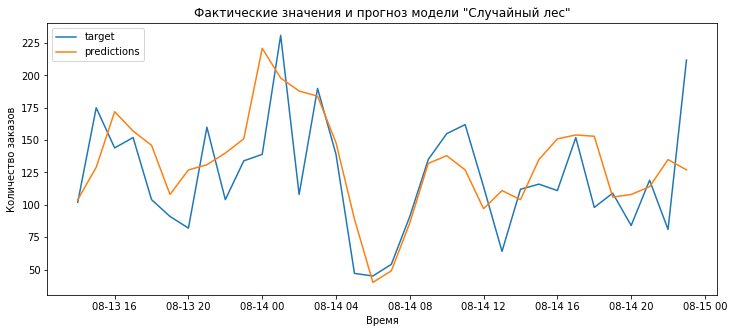

In [21]:
make_features(df, best_lag_rf, best_size_rf)

train_3, test_3 = train_test_split(df, shuffle=False, test_size=0.1)
train_3 = train_3.dropna()
features_train_3 = train_3.drop('num_orders', axis=1)
features_test_3 = test_3.drop('num_orders', axis=1)
target_train_3 = train_3['num_orders']
target_test_3 = test_3['num_orders'].reset_index()

model_rf = RandomForestRegressor(random_state=12345, max_depth=13, n_estimators=20)
model_rf.fit(features_train_3, target_train_3)
pred_test_3 = model_rf.predict(features_test_3)

pred_test_rf = pd.Series(pred_test_3)
target_test_rf = pd.concat([target_test_3, pred_test_rf], axis=1)
target_test_rf = target_test_rf.set_index('datetime')
target_test_rf.columns = ['target_test', 'pred_test']
target_test_rf['pred_test'] = target_test_rf['pred_test'].round()
target_test_rf.pred_test = target_test_rf.pred_test.astype(int)
df_for_plot_rf = target_test_rf['2018-08-13':'2018-08-14']
plt.figure(figsize=(12,5))
plt.plot(df_for_plot_rf['target_test'], label='target')
plt.plot(df_for_plot_rf['pred_test'], label='predictions')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.title('Фактические значения и прогноз модели "Случайный лес"')
plt.legend()
plt.show()

<div class="alert alert-block alert-info">
    
Исходя из графика сравнений фактических значений и прогнозируемых для трех моделей можно сделать вывод, что наиболее эффективно делает прогноз модель случайного леса, что подтверждается значением RMSE. 

## Сводная таблица

In [22]:
result_name = ['model_name', 'rmse']
result_lr = ['LinearRegression', int(best_result_lr)]
result_dt = ['DesicionTreeRegressor', int(best_result_dt)]
result_rf = ['RandomForestRegressor', int(best_result_rf)]

df_results = pd.DataFrame([result_lr, result_dt, result_rf], columns=result_name)

df_results.style.set_caption("Results of the different machine learning models")
df_results = df_results.sort_values('rmse', ascending=True).reset_index()
df_results.drop('index', axis=1, inplace=True)

df_results

,model_name,rmse
0,RandomForestRegressor,41
1,DesicionTreeRegressor,44
2,LinearRegression,49


## Вывод

<div class="alert alert-block alert-info">

**В проекте были выполнены следующие действия:**
    
  1. Проведена предобработка данных. 
  2. После проверки данных на монотонность данные были ресемплированы по одному часу.
  3. Выполнена декомпозиция, по графикам которой были сделаны выводы о сезонности и тренде.
  4. Выведен график скользящей средней для того, чтобы понять стационарность данных. 
  5. Создана функция "make_features" для формирования временных признаков, отстающих значений и скользящего среднего. Перед обчунием моделей былы произведена проверка на корректность деления данных на выборки. 
  6. Исходя из перебора условий создания признаков для временного ряда и прогнозов различных моделей с подобранными гиперпараметрами была рассчитана метрика: RMSE, которая выражается в натуральных единицах. 
  7. Представлена сводная таблица с результатами.
    
**Исходя из полученных данных можно сделать следующий вывод:**   
  - Наиболее эффективной моделью оказалась модель случайного леса с подобранными параметрами: lag=1, rolling_size=768, max_depth=14, n_estimators=20. Метрика RMSE=42 поездки. Это наименьший показатель среди всех моделей. Значение немного меньше заданного (48), но это лучший результат, которого удалось достичь. 
  - Второй по эффективности моделей оказалась модель дерева решений с параметром depth=9. RMSE у данной модели ниже, чем у случайного леса, однако скорость выполнения выше.
  - Результат метрики у модели линейной регрессии получился неудовлетворительный для заданного значения (48) - 49.   